In [ ]:
# === Install once per runtime ===
!pip -q install wbgapi plotly folium networkx seaborn pandas numpy matplotlib requests


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import wbgapi as wb
import plotly.express as px
import folium
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import requests, io, json
from datetime import datetime

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (9,6)
sns.set(style="whitegrid", font_scale=1.1)

# تأكد من الاتصال بمصدر WDI الافتراضي
wb.source.info()


id,name,code,concepts,lastupdated
1,Doing Business,DBS,3,2021-08-18
2,World Development Indicators,WDI,3,2025-10-07
3,Worldwide Governance Indicators,WGI,3,2024-11-05
5,Subnational Malnutrition Database,SNM,3,2016-03-21
6,International Debt Statistics,IDS,4,2025-02-26
11,Africa Development Indicators,ADI,3,2013-02-22
12,Education Statistics,EDS,3,2024-06-25
13,Enterprise Surveys,ESY,3,2022-03-25
14,Gender Statistics,GDS,3,2025-10-10
15,Global Economic Monitor,GEM,3,2025-10-24


In [ ]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import wbgapi as wb
import plotly.express as px
import folium
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import requests, io, json
from datetime import datetime

pd.set_option('display.max_columns', 50)
plt.rcParams['figure.figsize'] = (9,6)
sns.set(style="whitegrid", font_scale=1.1)

# تأكد من الاتصال بمصدر WDI الافتراضي
wb.source.info()

# نختار المؤشرات المطلوبة
INDICATORS = {
    'NY.GDP.MKTP.CD': 'GDP_Current_USD',          # GDP current US$
    'SP.DYN.LE00.IN': 'Life_Expectancy',          # Life expectancy at birth, total (years)
    'IT.NET.USER.ZS': 'Internet_Users_Pct',       # Individuals using the Internet (% of population)
    'SP.POP.TOTL'   : 'Population'                # Population, total
}

# نطاق السنوات (يمكن تعديله)
START_YEAR, END_YEAR = 1990, datetime.now().year

# تحميل بيانات المؤشرات لجميع الدول
# wbgapi يعيد MultiIndex (economy, time) -> نقوم بتحويله لإطار صفوف أعوام ودول
df_list = []
for code, newname in INDICATORS.items():
    d = wb.data.DataFrame(code, time=range(START_YEAR, END_YEAR+1))
    # Modified: Melt the dataframe to transform year columns into a 'Year' column
    d_melted = d.reset_index().melt(id_vars='economy', var_name='Year', value_name=newname)
    # Convert 'Year' column from 'YRXXXX' format to integer
    d_melted['Year'] = d_melted['Year'].str.replace('YR', '').astype(int)
    df_list.append(d_melted)


# الدمج على (economy, Year)
from functools import reduce
df = reduce(lambda left,right: pd.merge(left,right, on=['economy','Year'], how='outer'), df_list)

# إضافة أسماء الدول والمناطق
meta = wb.economy.DataFrame().reset_index()[['id','name','region','adminregion','incomeLevel','lendingType']]
meta = meta.rename(columns={'id':'economy', 'name':'Country', 'region':'Region', 'incomeLevel':'Income'})
df = df.merge(meta, on='economy', how='left')

# تنظيف:
# - حذف الكيانات التي ليست دولاً (مثل world aggregates) عبر Region != 'Aggregates'
df = df[df['Region'] != 'Aggregates'].copy()

# أنواع البيانات
df['Year'] = df['Year'].astype(int)
for col in ['GDP_Current_USD','Life_Expectancy','Internet_Users_Pct','Population']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# إسقاط الصفوف الفارغة تماماً على المتغيرات الرئيسة
df_clean = df.dropna(subset=['GDP_Current_USD','Life_Expectancy','Population'])

# معاينة
df_clean.head()

,economy,Year,GDP_Current_USD,Life_Expectancy,Internet_Users_Pct,Population,Country,Region,adminregion,Income,lendingType
0,ABW,1990,7.648045e+08,72.546,0.0,62753.0,Aruba,LCN,,HIC,LNX
1,ABW,1991,8.720670e+08,72.592,NaN,65896.0,Aruba,LCN,,HIC,LNX
2,ABW,1992,9.586592e+08,72.717,NaN,69005.0,Aruba,LCN,,HIC,LNX
3,ABW,1993,1.083240e+09,72.777,NaN,73685.0,Aruba,LCN,,HIC,LNX
4,ABW,1994,1.245810e+09,72.796,NaN,77595.0,Aruba,LCN,,HIC,LNX


In [ ]:
# أحدث سنة تتوفر فيها "العمر المتوقع" و"السكان" و"الناتج"
recent = (df_clean
          .sort_values(['economy','Year'])
          .dropna(subset=['Life_Expectancy','GDP_Current_USD','Population'])
          .groupby('economy', as_index=False)
          .tail(1)
          .copy())

# إضافة عام المرجع
recent_years = recent['Year'].describe()[['min','max']]
print("Most recent snapshot spans years:", dict(recent_years))
recent[['Country','Year','Life_Expectancy','GDP_Current_USD','Population','Internet_Users_Pct']].head()


Most recent snapshot spans years: {'min': np.float64(2011.0), 'max': np.float64(2023.0)}


,Country,Year,Life_Expectancy,GDP_Current_USD,Population,Internet_Users_Pct
33,Aruba,2023,76.353000,3.648573e+09,107359.0,NaN
68,Africa Eastern and Southern,2023,65.146291,1.133818e+12,750503764.0,32.4000
103,Afghanistan,2023,66.035000,1.715223e+10,41454761.0,17.7089
138,Africa Western and Central,2023,58.855722,8.147285e+11,509398589.0,38.1000
173,Angola,2023,64.617000,8.487516e+10,36749906.0,44.7581


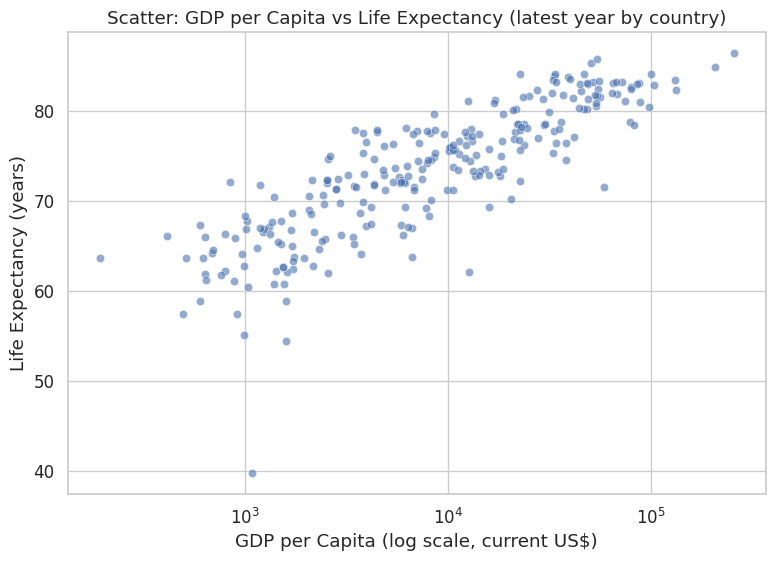

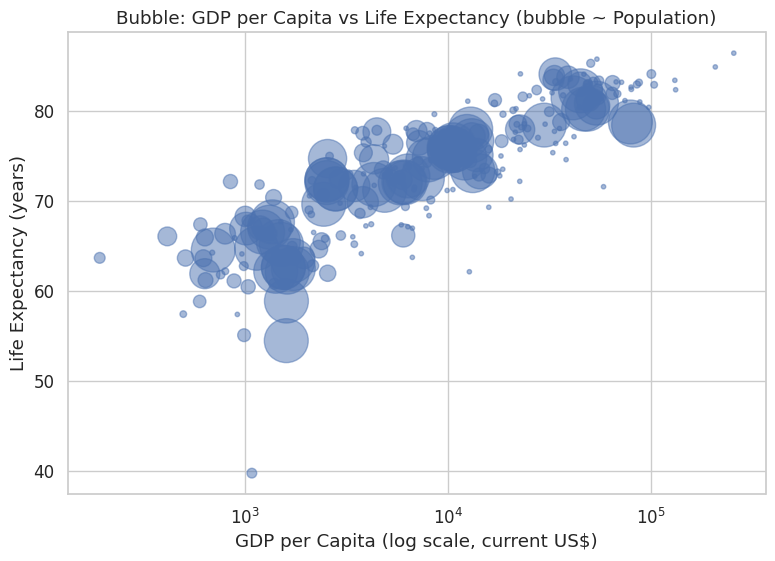

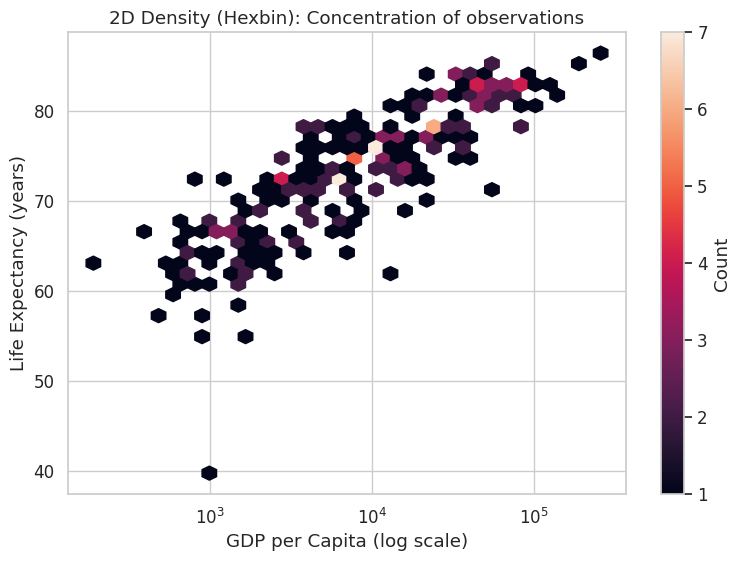

In [ ]:
# A) Scatter: GDP per capita (log) vs Life Expectancy
# GDP per Capita = GDP_Current_USD / Population
recent['GDP_Per_Capita'] = recent['GDP_Current_USD'] / recent['Population']

# Scatter بسيط (Matplotlib/Seaborn)
ax = sns.scatterplot(data=recent, x='GDP_Per_Capita', y='Life_Expectancy', alpha=0.6, edgecolor='white', linewidth=0.5)
ax.set_xscale('log')
ax.set_xlabel('GDP per Capita (log scale, current US$)')
ax.set_ylabel('Life Expectancy (years)')
ax.set_title('Scatter: GDP per Capita vs Life Expectancy (latest year by country)')
plt.show()

# B) Bubble chart (بحجم السكان)
# نطبع بفقاعات، مع تحجيم منطقي للحجم
size = (recent['Population'] / recent['Population'].quantile(0.75)) * 300
size = size.clip(10, 1000)  # قصّ الأحجام لمنع التضخم البصري
ax = plt.figure().gca()
plt.scatter(recent['GDP_Per_Capita'], recent['Life_Expectancy'], s=size, alpha=0.5)
ax.set_xscale('log')
plt.xlabel('GDP per Capita (log scale, current US$)')
plt.ylabel('Life Expectancy (years)')
plt.title('Bubble: GDP per Capita vs Life Expectancy (bubble ~ Population)')
plt.show()

# C) 2D Density (Hexbin أو KDE)
# Hexbin
ax = plt.figure().gca()
hb = ax.hexbin(recent['GDP_Per_Capita'], recent['Life_Expectancy'], gridsize=35, xscale='log', mincnt=1)
plt.xlabel('GDP per Capita (log scale)')
plt.ylabel('Life Expectancy (years)')
plt.title('2D Density (Hexbin): Concentration of observations')
cb = plt.colorbar(hb)
cb.set_label('Count')
plt.show()

# أو KDE (تعليق الافتراضي لمنع ثقل)، فعّل إذا رغبت
# sns.kdeplot(
#     data=recent, x='GDP_Per_Capita', y='Life_Expectancy',
#     fill=True, thresh=0.05, levels=30, cmap='mako'
# )
# plt.xscale('log'); plt.title('2D KDE Density'); plt.show()


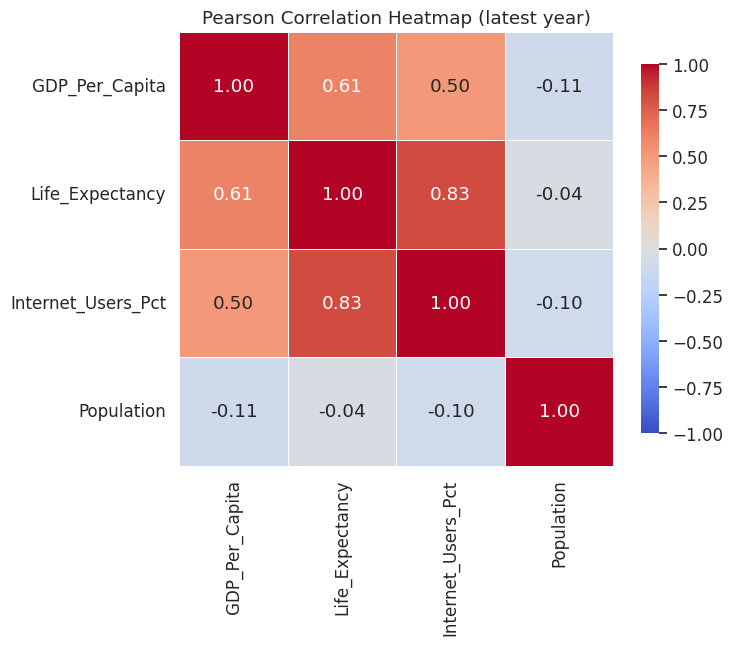

,GDP_Per_Capita,Life_Expectancy,Internet_Users_Pct,Population
GDP_Per_Capita,1.000000,0.609347,0.503312,-0.107406
Life_Expectancy,0.609347,1.000000,0.827517,-0.042943
Internet_Users_Pct,0.503312,0.827517,1.000000,-0.097343
Population,-0.107406,-0.042943,-0.097343,1.000000


In [ ]:
# حساب مصفوفة الارتباط بيرسون
corr_vars = ['GDP_Per_Capita','Life_Expectancy','Internet_Users_Pct','Population']
corr_df = recent[corr_vars].copy()
corr = corr_df.corr(method='pearson')

# Heatmap مع تدرج متباين وكتابة القيم
plt.figure(figsize=(7,6))
ax = sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, linewidths=0.5, cbar_kws={'shrink':0.8})
plt.title('Pearson Correlation Heatmap (latest year)')
plt.show()

corr


In [ ]:
# نختار دولتين: متقدمة (United States USA) ونامية (India IND) — يمكنك التبديل كما تشاء
countries_iso3 = ['USA','IND']

ts = df[df['economy'].isin(countries_iso3)][['Country','Year','GDP_Current_USD','Population']].dropna()
ts['GDP_Per_Capita'] = ts['GDP_Current_USD'] / ts['Population']

fig = px.line(
    ts.sort_values('Year'),
    x='Year', y='GDP_Per_Capita', color='Country',
    title='Interactive GDP per Capita over time (USA vs IND)',
    labels={'GDP_Per_Capita':'GDP per Capita (current US$)'}
)
fig.update_yaxes(type='log')  # مقياس لوغاريتمي لتمييز الفروقات
fig.update_layout(hovermode='x unified')
fig.show()


In [ ]:
import numpy as np
import pandas as pd
import networkx as nx

# تأكيد وجود recent
try:
    recent
except NameError:
    raise RuntimeError("البيانات recent غير متاحة. شغّلي خلية A أو خلية التحميل الأساسية أولًا.")

base = recent[['Region','Country','economy','Population','GDP_Current_USD']].dropna(subset=['Region','Country']).copy()

# لتخفيف الزحام: أعلى n دول سكانًا بكل إقليم
n_per_region = 10
base['rank_pop'] = base.groupby('Region')['Population'].rank(ascending=False, method='first')
sub = base[base['rank_pop'] <= n_per_region].copy()

# Graph
G = nx.DiGraph()
G.add_node('World', level=0)
for reg in sorted(sub['Region'].unique()):
    G.add_node(reg, level=1)
    G.add_edge('World', reg)           # World → Region
for reg, grp in sub.groupby('Region'):
    for _, r in grp.iterrows():
        G.add_node(r['Country'], level=2,
                   population=float(r['Population']),
                   gdp=float(r['GDP_Current_USD']))
        G.add_edge(reg, r['Country'])  # Region → Country

print(f"Graph ready. Nodes={G.number_of_nodes()}, Edges={G.number_of_edges()}")


Graph ready. Nodes=77, Edges=77


In [ ]:
# تجهيز إطار بيانات لأحدث سنة لكل دولة
map_df = recent[['economy', 'Country', 'Life_Expectancy','Year']].dropna().copy()

# GeoJSON لحدود دول العالم (مصدر عام GitHub)
geojson_url = "https://raw.githubusercontent.com/python-visualization/folium/main/examples/data/world-countries.json"
geojson_data = requests.get(geojson_url).json()

# Extract ISO2 codes from geojson data for potential mapping
geojson_ids = [feature['id'] for feature in geojson_data['features']]

# Function to attempt mapping economy code to ISO2
# This is a simplified approach and might need refinement for some cases
# A more robust approach would involve a lookup table or another API call
def map_economy_to_iso2(economy_code, geojson_ids):
    # Simple heuristic: if economy code is 3 characters, try to find a match
    if len(economy_code) == 3:
        # This is a very basic mapping. A proper mapping requires a lookup.
        # For demonstration, let's assume ISO3 can sometimes be mapped to ISO2
        # or that we can infer it if it exists in the geojson ids.
        # A real solution would involve a dedicated mapping.
        pass # Placeholder for a more complex mapping logic if needed

    # If direct mapping is not feasible or reliable, we will rely on the
    # choropleth's key_on to match based on the 'economy' column if possible,
    # or inform the user that a proper mapping is needed.
    return None # Indicate that automatic mapping is not reliable here


# Add a placeholder for ISO2 if needed, though we'll try to match on 'economy' directly
# map_df['ISO2'] = map_df['economy'].apply(lambda x: map_economy_to_iso2(x, geojson_ids))


# إنشاء الخريطة
center = [20, 0]  # تقريبي لمركز العالم
m = folium.Map(location=center, zoom_start=2, tiles='cartodbpositron')

# Folium Choropleth يعتمد على مطابقة المفتاح.
# We will try to match using the 'economy' column from our data
# and the 'id' field from the geojson data.
folium.Choropleth(
    geo_data=geojson_data,
    data=map_df,
    columns=['economy','Life_Expectancy'], # Use 'economy' column for matching
    key_on='feature.id',         # world-countries.json uses ISO2 in feature.id
    fill_color='YlGnBu',
    fill_opacity=0.8,
    line_opacity=0.2,
    nan_fill_opacity=0.15,
    legend_name=f'Life Expectancy (years), latest ~{int(map_df["Year"].median())}'
).add_to(m)

# Tooltip/Popup
folium.GeoJsonTooltip(
    fields=['name'],
    aliases=['Country:']
).add_to(folium.GeoJson(
    geojson_data,
    style_function=lambda x: {'fillColor': 'transparent', 'color':'transparent', 'weight':0}
))

# نقاط بسيطة لعرض قيم الدولة عند المرور
# This loop is not adding markers with data, so we can remove it or modify
# it to add markers with tooltips if we had latitude/longitude.
# For now, we rely on the choropleth's implicit tooltip on hover.
# for _, r in map_df.iterrows():
#     folium.CircleMarker(
#         location=None,  # لا نملك lat/lon هنا سريعاً؛ نكتفي بالـ choropleth والtooltip العام
#         radius=0
#     )

m

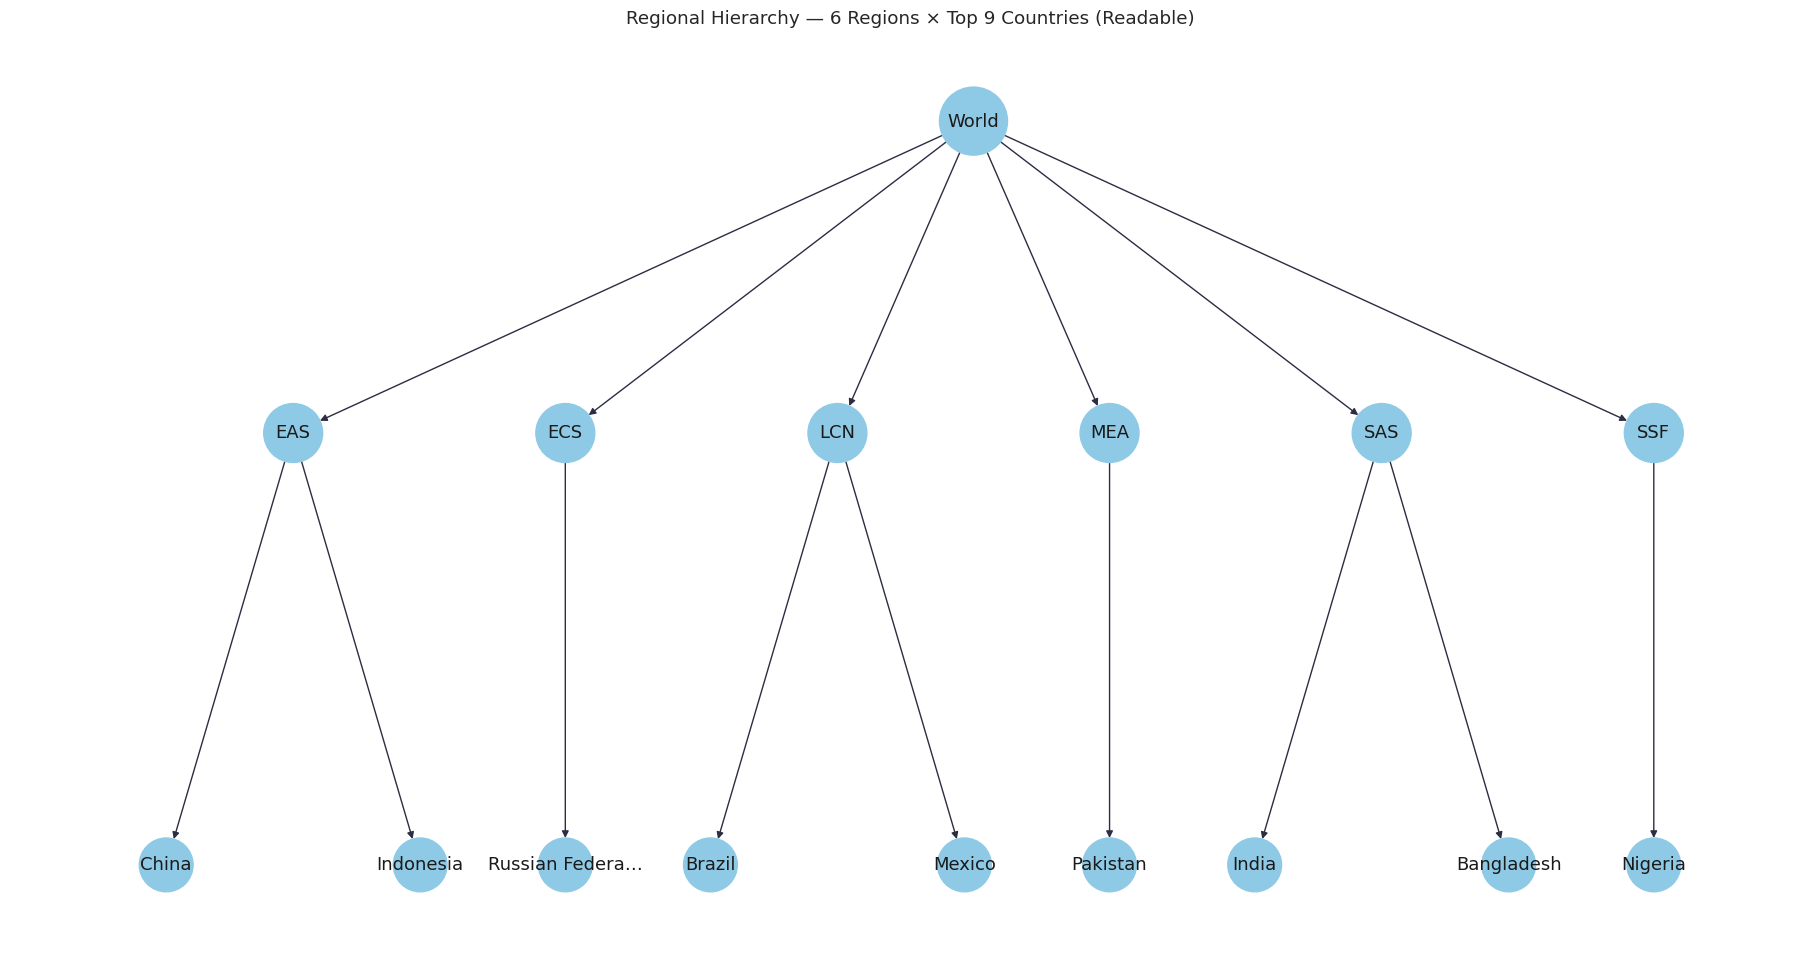

In [ ]:
# === Regional Hierarchy (6 regions, top 9 countries total, bigger readable nodes) ===
import matplotlib.pyplot as plt, networkx as nx
import pandas as pd

# تأكدي من وجود recent بالحقول اللازمة
need = {'Region','Country','Population','GDP_Current_USD'}
assert 'recent' in globals() and need.issubset(recent.columns), "شغّلي خلية إعداد البيانات أولاً."

# نحافظ على 6 أقاليم، ونختار أعلى 9 دول سكانًا إجمالًا عبر هذه الأقاليم
keep_regions = ['EAS','ECS','LCN','MEA','SAS','SSF']
base = (recent[recent['Region'].isin(keep_regions)]
        [['Region','Country','Population','GDP_Current_USD']]
        .dropna())
top_countries = base.sort_values('Population', ascending=False).head(9)

# ابني الرسم: World → Regions → Countries(التسعة فقط)
G = nx.DiGraph(); G.add_node('World', level=0)
for r in keep_regions: G.add_node(r, level=1); G.add_edge('World', r)
for _, row in top_countries.iterrows():
    G.add_node(row['Country'], level=2)
    G.add_edge(row['Region'], row['Country'])

# تموضع بسيط
pos = {'World': (0.5, 1.00)}
regions = [n for n,d in G.nodes(data=True) if d.get('level')==1]
for i, r in enumerate(regions): pos[r] = ((i+1)/(len(regions)+1), 0.74)
for r in regions:
    ch = list(G.successors(r)); m = len(ch)
    for j, c in enumerate(ch):
        pos[c] = (pos[r][0] - 0.20 + 0.40*((j+1)/(m+1)), 0.38)

# أحجام كبيرة للوضوح + تسميات مختصرة للدول
sizes = [2400 if G.nodes[n]['level']==0 else 1800 if G.nodes[n]['level']==1 else 1500 for n in G.nodes()]
labels = {n: (n.split(',')[0][:14] + ('…' if len(n)>14 else '')) if G.nodes[n]['level']==2 else n for n in G.nodes()}

plt.figure(figsize=(18,9))
nx.draw(G, pos, with_labels=True, labels=labels,
        node_size=sizes, node_color="#8ecae6", edge_color="#2b2d42",
        arrows=True, width=1.0, font_size=13)
plt.title("Regional Hierarchy — 6 Regions × Top 9 Countries (Readable)", pad=14)
plt.axis('off'); plt.show()


# 1️⃣ تبرير اختيار المخطط الأفضل (Lab 4.2 – Comparative Chart Choice)

المخطط الأنسب هو مخطط الفقاعات (Bubble Chart) لأنه يدمج بين علاقة GDP_Per_Capita ↔ Life_Expectancy ويُظهر البُعد الثالث (عدد السكان) من خلال حجم الفقاعة.
هذا يُتيح فهم التأثير النسبي للدول كثيرة السكان على المتوسط العالمي، خصوصًا في فئات الدخل المتوسطة.
في حين يوضح Scatter العلاقة فقط دون الوزن، ويُظهر Density التكتلات لكنه يفقد معلومات الدول الفردية.
لذلك، الـ Bubble Chart هو الأكثر فاعلية في توصيل الرسالة المطلوبة.

# 2️⃣ تفسير خريطة الارتباط (Heatmap – Correlation Analysis)

عادةً ما يظهر ارتباط قوي موجب بين:

GDP_Per_Capita و Life_Expectancy،

أو بين Internet_Users_Pct و GDP_Per_Capita.

هذا الارتباط يعكس أن الدول ذات الدخل الأعلى غالبًا ما تمتلك:

بنية تحتية وتقنيات اتصالات متطورة،

خدمات صحية وتعليمية أفضل،

ومستوى رفاهية أعلى ينعكس في العمر المتوقع.

أما Population، فعلاقته ببقية المؤشرات ليست خطية:
قد تكون الدول ذات السكان الكُثر عند مستويات دخل وصحة متوسطة، لكنها تُؤثر بقوة على المتوسطات العالمية عند حسابها بالوزن السكاني (Weighted Averages).

# 3️⃣ مناقشة رسم العلاقات الهرمية (NetworkX – Hierarchy & Relationships)

يمكن تطوير الرسم ليعكس علاقات اقتصادية حقيقية بين الدول، من خلال استخدام شبكات موجهة وموزونة تعبّر عن حجم الترابط. ومن البيانات التي يمكن إدخالها:

مصفوفات التجارة الثنائية (قيمة الصادرات والواردات بين كل دولتين).

تدفقات الاستثمار الأجنبي المباشر (FDI).

شبكات سلاسل التوريد العالمية (مدخلات – مخرجات القطاعات).

الاتفاقيات التجارية والتعريفات الجمركية.

في هذه الحالة:

يمكن وزن الحواف (edges) بقيمة التجارة أو الاستثمار.

وزن العقد (nodes) بـ GDP أو عدد السكان.

استخدام مقاييس مركزية مثل Degree و Betweenness لتحديد “العُقد المحورية” في الاقتصاد العالمي.